# **Dashboard**


In [3]:
#Graphdatenbankanbindung
import py2neo

graph = py2neo.Graph(bolt=True, host='localhost', user='neo4j', password='neo4j')

In [4]:
#html für pygal laden

from IPython.display import display, HTML

base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

# Systemgröße
In dem Gauge Systemgröße wird das Programm eingeordnet nach der Größe seines Systems.
Die Einteilung erfolgt auf Grundlage der Anzahl der Quelltextzeilen.
Anhand dieser Analyse ist es möglich, das Programm grob im Hinblick auf Komplexität und Größe einzuordnen.

*sehr klein: kleiner gleich 10000; klein: zwischen 10000 und 50000; mittel: zwischen 50000 und 200000; groß: zwischen 200000 und 500000; sehr groß: über 500000*

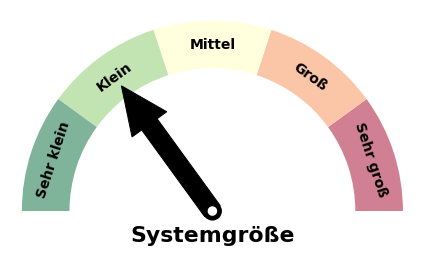

In [8]:
#Systemgröße

#Cypher Abfrage
import pandas as pd

query ="MATCH (t:Type)-[:HAS_SOURCE]->(f), (t)-[:DECLARES]->(m:Method) RETURN sum(m.effectiveLineCount) as loc"
df = pd.DataFrame(graph.run(query).data())

#Visualisierung
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Wedge, Rectangle
import numpy as np
import plotly.plotly as py
import plotly.tools as tls

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['Sehr klein','Klein','Mittel','Groß','Sehr Groß'], \
          colors='jet_r', arrow=1, title='', fname=False): 
    
    """
    some sanity checks first
    
    """
    
    N = len(labels)
    
    if arrow > N: 
        raise Exception("\n\nThe category ({}) is greated than \
        the length\nof the labels ({})".format(arrow, N))
 
    
    """
    if colors is a string, we assume it's a matplotlib colormap
    and we discretize in N discrete colors 
    """
    
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors, N)
        cmap = cmap(np.arange(N))
        colors = cmap[::-1,:].tolist()
    if isinstance(colors, list): 
        if len(colors) == N:
            colors = colors[::-1]
        else: 
            raise Exception("\n\nnumber of colors {} not equal \
            to number of categories{}\n".format(len(colors), N))

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = mid_points[abs(arrow - N)]
    
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

#Analyse
loc=df.iloc[0]['loc']
def calculate_level(loc):
    if loc<=10000:
        t=1
    elif loc<=50000:
        t=2
    elif loc<=200000:
        t=3
    elif loc<=500000:
        t=4
    else:
        t=5
    return(t)

#Visualisierung
gauge(labels=['Sehr klein','Klein','Mittel','Groß','Sehr groß'], \
        colors='RdYlGn', arrow=calculate_level(loc), title='Systemgröße')

# Testabdeckung

In dem Gauge Testabdeckung wird gezeiigt, welcher Anteil des Programms getestet wird.
Die Einteilung erfolgt auf Grundlage der Anzahl der Testabdeckung. Die Testabdeckung ist das Verhältnis von den getroffenen Aussagen eines Testdurchlaufs im Verhältnis zu den möglichen Aussagen, die getroffen werden können. Je höher die Testabdeckung ist, desto mehr eventuell eintreffende Fehlern konnte vorgebeugt werden.

*sehr gering: kleiner gleich 20%; gering: zwischen 20% und 40%; mittel: zwischen 40% und 60%; hoch: zwischen 60% und 80%; sehr hoch: über 80%*

5


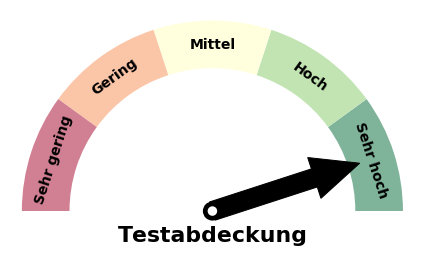

In [19]:
#Testabdeckung

#Cypher Abfrage
import pandas as pd

query ="MATCH (c:Jacoco:Class)-[:HAS_METHOD]->(m:Method:Jacoco)-[:HAS_COUNTER]->(t:Counter) WHERE t.type='INSTRUCTION' RETURN (sum(t.covered)*100)/(sum(t.covered)+sum(t.missed)) as coverage"
df = pd.DataFrame(graph.run(query).data())

#Visualisierung
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Wedge, Rectangle
import numpy as np

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['Sehr gering','Gering','Mittel','Hoch','Sehr Hoch'], \
          colors='jet_r', arrow=1, title='', fname=False): 
    
    """
    some sanity checks first
    
    """
    
    N = len(labels)
    
    if arrow > N: 
        raise Exception("\n\nThe category ({}) is greated than \
        the length\nof the labels ({})".format(arrow, N))
 
    
    """
    if colors is a string, we assume it's a matplotlib colormap
    and we discretize in N discrete colors 
    """
    
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors, N)
        cmap = cmap(np.arange(N))
        colors = cmap[::-1,:].tolist()
    if isinstance(colors, list): 
        if len(colors) == N:
            colors = colors[::-1]
        else: 
            raise Exception("\n\nnumber of colors {} not equal \
            to number of categories{}\n".format(len(colors), N))

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = mid_points[abs(arrow - N)]
    
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)

#Analyse
coverage=df.iloc[0]['coverage']
#loc in coverage umbenennen
def calculate_level(coverage):
    if loc<=20:
        level=1
    elif loc<=40:
        level=2
    elif loc<=60:
        level=3
    elif loc<=80:
        level=4
    else:
        level=5
    return(level)

print(calculate_level(coverage))

#Visualisierung ausgeben
gauge(labels=['Sehr gering','Gering','Mittel','Hoch','Sehr hoch'], \
      colors='RdYlGn_r', arrow=calculate_level(coverage), title='Testabdeckung') 

# Programmierverstöße

Im Radar Chart werden die Art der Programmierverstöße mit ihrer absoluten Anzahl dargestellt. Die Programmierverstöße werden in fünf Kategorien unterteilt. 
Dabei wird aufgezeigt, welche Qualität das Programm hinsichtlich Code Style, Error Prone, Multithreading, Best Practices und Design aufweist.

In [10]:
#Programmierverstöße

#Cypher Abfrage
import pandas as pd

query ="MATCH (:Report)-[:HAS_FILE]->(file:File:Pmd)-[:HAS_VIOLATION]->(violation:Violation) RETURN  violation.ruleSet as category, count(violation.ruleSet) as frequency"
df = pd.DataFrame(graph.run(query).data())

#Analyse

frequency=df['frequency'].tolist()


category=df['category'].tolist()

#Visualisierung
import pygal
radar_chart = pygal.Radar()
radar_chart.title = 'Programmierverstöße'
radar_chart.x_labels = category
radar_chart.add('Anzahl der Programmierverstöße', frequency)

display(HTML(base_html.format(rendered_chart=radar_chart.render(is_unicode=True))))


# Entwickler mit den meisten Commits

Im Balkendiagramm Entwickler mit den meisten Commits werden die zehn Entwickler mit den meisten Commits in Abhängigkeit der absoluten Anzahl ihrer Commits dargestellt.
Hier erkennt man, welcher Entwickler den meisten Anteil an dem Entwickeln des Programmes hatte.


In [11]:
#Entwickler

#Cypher Abfrage
import pandas as pd

query ="MATCH (a:Author)-[:COMMITTED]->(c:Commit)-[:CONTAINS_CHANGE]->(:Change)-[:MODIFIES]->(file:File) WHERE NOT c:Merge RETURN a.name as developer, count(distinct c) as commits"
df = pd.DataFrame(graph.run(query).data())

#Analyse
import numpy as np

a=df.sort_values('commits',ascending=False)
b=a.head(10)

def x_commits(x):
    x=b['commits'].tolist()
    return x


def y_developer(y):
    y=b['developer'].tolist()
    return(y)

#Visualisierung

import pygal 
line_chart = pygal.HorizontalBar()
line_chart.title = 'Entwickler mit den meisten Commits'
for einzelnerEntwickler in y_developer(b):
    index= y_developer(b).index(einzelnerEntwickler)
    #dazugehörige frequency herausbekommen
    anzahl=x_commits(b)[index]
    line_chart.add(einzelnerEntwickler, anzahl)
display(HTML(base_html.format(rendered_chart=line_chart.render(is_unicode=True))))

# Größte Methoden

Im Balkendiagramm Größte Methoden werden die zehn Methoden mit den meisten Quelltextzeilen in Abhängigkeit der absoluten Anzahl ihrer Quelltextzeilen dargestellt. Die größte Methode wird somit ermittelt.
Große Methoden sind prädestiniert für Fehler und sollten im Rahmen des Reengineerngs überarbeitet werden, z.B. in kleinere aufgeteilt.

In [16]:
#größte Methoden

#Cypher Abfrage
import pandas as pd

query ="MATCH (t:Type)-[:HAS_SOURCE]->(f), (t)-[:DECLARES]->(m:Method) RETURN t.fqn as type, m.signature as signature,  sum(m.effectiveLineCount) as loc, sum(m.cyclomaticComplexity) as complexity"
df = pd.DataFrame(graph.run(query).data())

#Analyse
a=df.sort_values('loc',ascending=False)
b=a.head(10)
def x_loc(x):
    x=b['loc'].tolist()
    return x
def y_method_loc(y):
    liste=[]
    y=b['signature'].tolist()
    for i in y:
        g=i.split(' ')[-1]
        liste.append(g)
    return liste

#Visualisierung
import pygal 
line_chart = pygal.HorizontalBar()
line_chart.title = 'Größte Methoden'
for einzelneMethode in y_method_loc(b):
    index= y_method_loc(b).index(einzelneMethode)
    #dazugehörige frequency herausbekommen
    anzahl=x_loc(b)[index]
    line_chart.add(einzelneMethode, anzahl)
display(HTML(base_html.format(rendered_chart=line_chart.render(is_unicode=True))))

# Komplexeste Methoden
Im Balkendiagramm Komplexeste Methoden werden die zehn Methoden der höchsten Komplexität in Abhängigkeit der absoluten Anzahl ihrer Quelltextzeilen dargestellt. Dabei werden die Anzahl der Rechenschritte /Speicherbedarf betrachtet.


In [13]:
#komplexeste Methoden

#Cypher Abfrage
import pandas as pd

query ="MATCH (t:Type)-[:HAS_SOURCE]->(f), (t)-[:DECLARES]->(m:Method) RETURN t.fqn as type, m.signature as signature,  sum(m.effectiveLineCount) as loc, sum(m.cyclomaticComplexity) as complexity"
df = pd.DataFrame(graph.run(query).data())

#Analyse
a=df.sort_values('complexity',ascending=False)
c=a.head(10)

def x_complexity(x):
    x=c['complexity'].tolist()
    return(x)

def y_method_complexity(y):
    liste=[]
    y=c['signature'].tolist()
    for i in y:
        g=i.split(' ')[-1]
        liste.append(g)
    return liste


#Visualisierung
import pygal 
line_chart = pygal.HorizontalBar()
line_chart.title = 'Komplexeste Methoden'
for einzelneMethode in y_method_complexity(c):
    index= y_method_complexity(c).index(einzelneMethode)
    #dazugehörige frequency herausbekommen
    anzahl=x_complexity(c)[index]
    line_chart.add(einzelneMethode, anzahl)
display(HTML(base_html.format(rendered_chart=line_chart.render(is_unicode=True))))

In [18]:
#Visualisierung 2 für 5
import pygal 
line_chart = pygal.HorizontalBar()
line_chart.title = 'Komplexeste Methoden'
line_chart.x_labels= y_method_complexity(c)
line_chart.add('Programm 1',x_complexity(c))
display(HTML(base_html.format(rendered_chart=line_chart.render(is_unicode=True))))


# Dateitypen
Das vorliegende Kreisdiagramm Dateitypen visualisiert die prozentuale Häufigkeit der benutzten Dateitypen. Dateitypen mit einer absoluten Häufigkeit kleiner gleich 3 werden unter Andere zusammengefasst. Man kann damit das Programm näher kennenlernen und herausfinden, welche Programmiersprache am meisten eingesetzt wurde.

In [15]:
#Dateitypen

#Cypher Abfrage
import pandas as pd

query ="MATCH (f:Git:File) RETURN f.relativePath as relativePath"
df = pd.DataFrame(graph.run(query).data())
#Analyse
datatypes = df['relativePath'].str.rsplit('.', 1).str[1]
series = datatypes.value_counts()
datatype = list(series.index)
frequency = list(series)
# Erzeuge die Kategorie "andere", in der alle Dateitypen gesammelt werden, die weniger oder genau 20 mal auftauchen
andere = 0
for wert in frequency[:]:
    index = frequency.index(wert)
    if wert <= 20:
        andere += wert
        datatype.remove(datatype[index])
        frequency.remove(wert)
frequency.append(andere)
datatype.append("andere")

#Visualisierung
import pygal 
pie_chart = pygal.Pie()
pie_chart.title = 'Dateitypen'
for einzelneDateitypen in datatype:
    index= datatype.index(einzelneDateitypen)
    #dazugehörige frequency herausbekommen
    anzahl=frequency[index]
    pie_chart.add(einzelneDateitypen, anzahl)
display(HTML(base_html.format(rendered_chart=pie_chart.render(is_unicode=True))))